<a href="https://colab.research.google.com/github/Bhuvan588/Pneumonia-Detection-Using-Xception-Model/blob/main/Pneumonia_Detection_using_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Extracting dataset using Kaggle API command

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [01:00<00:00, 42.4MB/s]
100% 2.29G/2.29G [01:00<00:00, 40.4MB/s]


In [ ]:
from zipfile import ZipFile
with ZipFile("chest-xray-pneumonia.zip","r") as zip:
  zip.extractall()
print("Extraction done")

Extraction done


Importing required libraries

In [ ]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

from sklearn.preprocessing import LabelEncoder


#Tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from keras import *


# Warnings
import warnings
warnings.filterwarnings("ignore")

Splitting into training , validation and test datasets

In [ ]:
data_dir ="chest_xray/train"
test_dir = "chest_xray/test"

IMAGE_SIZE  =(299, 299)
BATCH_SIZE = 32

print('Training Images:')
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset='training',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

print('Validation Images:')
validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset='validation',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

print('Testing Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)


Training Images:
Found 5216 files belonging to 2 classes.
Using 4695 files for training.
Validation Images:
Found 5216 files belonging to 2 classes.
Using 521 files for validation.
Testing Images:
Found 624 files belonging to 2 classes.


In this part we will encode the labels of the dataset using LabelEncoder

In [ ]:
#First we need to extract the labels

train_labels  = train_ds.class_names
test_labels = test_ds.class_names
val_labels = validation_ds.class_names

#Defining the class names
class_labels = ["NORMAL", "PNEUMONIA"]

#Creating object of label encoder
label_encoder  =  LabelEncoder()

#First we fit and then transform for each set
label_encoder.fit(class_labels)

train_labels_encoded  =  label_encoder.transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)
val_labels_encoded = label_encoder.transform(val_labels)

Visualizing some images

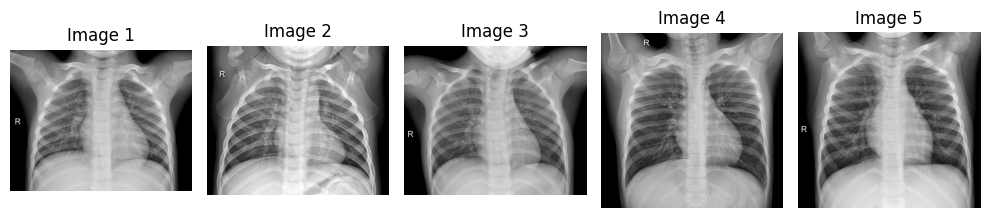

In [ ]:
import os

# Directory containing the images
normal = "chest_xray/train/NORMAL"

# List all image files in the directory
images = os.listdir(normal)

# Display the first 5 images
plt.figure(figsize=(10, 10))
for i, image_name in enumerate(images[:5]):  # Display only the first 5 images
    image_path = os.path.join(normal, image_name)  # Create the full path of the image
    image = cv2.imread(image_path)  # Read the image using OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image from BGR to RGB format

    # Display the image
    plt.subplot(1, 5, i + 1)  # Adjust subplot to display 5 images in a row
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Image {i+1}")

plt.tight_layout()
plt.show()

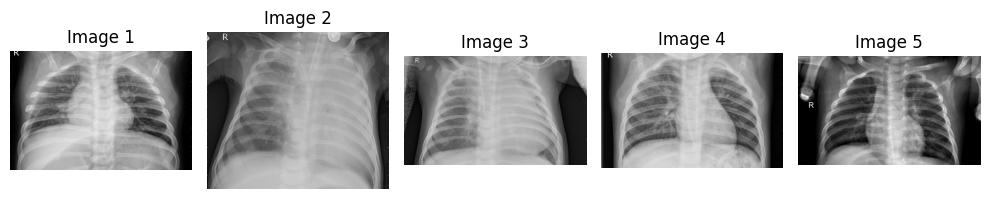

In [ ]:


# Directory containing the images
normal = "chest_xray/train/PNEUMONIA"

# List all image files in the directory
images = os.listdir(normal)

# Display the first 5 images
plt.figure(figsize=(10, 10))
for i, image_name in enumerate(images[:5]):  # Display only the first 5 images
    image_path = os.path.join(normal, image_name)  # Create the full path of the image
    image = cv2.imread(image_path)  # Read the image using OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image from BGR to RGB format

    # Display the image
    plt.subplot(1, 5, i + 1)  # Adjust subplot to display 5 images in a row
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Image {i+1}")

plt.tight_layout()
plt.show()

Now we will build our model using transfer learning. We will use Xception model as the base and we will add our own layers at the top

In [ ]:
from tensorflow import keras

#Loading the base which is the Xception model which was pretrained on the ImageNet dataset
base_model = keras.applications.Xception(weights="imagenet", include_top=False, pooling ="avg", input_shape=(299,299,3))

base_model.trainable = False


#Now we will add our own layers
model = keras.models.Sequential()
model.add(keras.Input(shape=(299, 299, 3))) #Input layer
model.add(base_model)

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.45))
model.add(keras.layers.Dense(220, activation = "relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation = "relu"))
model.add(keras.layers.Dense(1, activation = "sigmoid"))

model.compile(optimizer = keras.optimizers.Adamax(learning_rate =0.001), loss = "binary_crossentropy", metrics = ["accuracy"])

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 220)                 │         450,780 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 220)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 60)                  │          13,260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              61 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,333,773 (81.38 MB)

 Trainable params: 468,197 (1.79 MB)

 Non-trainable params: 20,865,576 (79.60 MB)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Fitting Model
history = model.fit(train_ds,epochs= 10, validation_data = validation_ds, callbacks = early_stopping)

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 101s 489ms/step - accuracy: 0.8678 - loss: 0.3075 - val_accuracy: 0.8906 - val_loss: 0.2513
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 94s 311ms/step - accuracy: 0.9306 - loss: 0.1648 - val_accuracy: 0.9501 - val_loss: 0.1380
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 83s 317ms/step - accuracy: 0.9456 - loss: 0.1467 - val_accuracy: 0.9597 - val_loss: 0.1190
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 81s 311ms/step - accuracy: 0.9415 - loss: 0.1451 - val_accuracy: 0.9616 - val_loss: 0.1135
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 45s 302ms/step - accuracy: 0.9468 - loss: 0.1324 - val_accuracy: 0.9578 - val_loss: 0.1055
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 83s 311ms/step - accuracy: 0.9523 - loss: 0.1281 - val_accuracy: 0.9539 - val_loss: 0.1072
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 81s 303ms/step - accuracy: 0.9563 - loss: 0.1268 - val_accuracy: 0.9559 - val_loss: 0.1076
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 83s 310ms/step - accuracy: 0.9615 - loss: 

Saving the model

In [ ]:
model.save("pneumonia-model.h5")